https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [51]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline
import torch
from bs4 import BeautifulSoup
import re
from configs import NEWS_SAVE_FILE
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [16]:
tokens = tokenizer.encode("I hated this, pretty bad", return_tensors='pt')
tokens

tensor([[  101,   151, 39487, 10163, 10372,   117, 31897, 12428,   102]])

In [17]:
tokenizer.decode(tokens[0])

'[CLS] i hated this, pretty bad [SEP]'

In [18]:
result = model(tokens)
result

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.8734,  2.0596,  0.3354, -1.9716, -2.6467]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [19]:
torch.argmax(result.logits)

tensor(0)

In [20]:
df = pd.read_pickle(NEWS_SAVE_FILE)
print(df.shape)
df.sample(5)

(10028, 9)


,headline,publish_date,content,authors,keywords,summary,source,url,date_pulled
622,Sick With Something That Isn't COVID-19 or the...,2023-03-20 18:44:52+00:00,"Flu season is wrapping up, and weekly COVID-19...",[Jamie Ducharme],"[viruses, heres, flu, sick, respiratory, cdc, ...","Flu season is wrapping up, and weekly COVID-19...",time,https://time.com/,03-21-23
8420,Why are gas prices rising? 2023 has seen a spi...,2023-04-14 00:00:00,"The weather is heating up, and so are gas pric...",[],"[spring, spike, heres, gallon, high, 2023, ris...","The weather is heating up, and so are gas pric...",usatoday,https://www.usatoday.com/,04-16-23
4060,'Live free and die'? The sad state of U.S. lif...,2023-03-25 00:00:00,'Live free and die'? The sad state of U.S. lif...,[Selena Simmons-Duffin],"[die, americans, nih, shorter, health, life, s...",The sad state of U.S. life expectancyLoading.....,npr,https://www.npr.org/sections/news/,03-26-23
8696,Video Shanquella Robinson’s family are demandi...,NaT,Shanquella Robinson’s family are demanding ans...,[Abc News],"[doj, justice, demanding, mexico, robinsons, v...",Shanquella Robinson’s family are demanding ans...,abcnews.go,https://abcnews.go.com/,04-16-23
7579,Celebrate National Margarita Day with these sw...,NaT,National Margarita Day is Feb. 22 — so what be...,[Ashlyn Messier],"[ice, ingredients, salt, national, day, ounces...",National Margarita Day is Feb. 22 — so what be...,foxnews,https://www.foxnews.com/,04-16-23


In [21]:
def tokenize_and_predict(text: str):
    """
    Takes some text in string format (words separated by spaces), tokenizes it and predicts sentiment based on BERT model.
    The output is a number between 1 and 5. In order to interpret as sentiment think of it as 1 start review to 5 star review. (5 being most positive).
    """
    tokens = tokenizer.encode(text, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits)) + 1

In [22]:
#takes 8 minutes to run on 10k rows. Which means 0.048 seconds per row
df['BERT_headline_sentiment_score'] = df['headline'].apply(tokenize_and_predict)

In [25]:
#takes xxxx minutes to run on 10k rows. Which means xxx minutes per row
# df['BERT_content_sentiment_score'] = df['content'].apply(tokenize_and_predict)
#can't do content becuase the maximum sequence length of the model is 512.

In [28]:
df[['headline', 'BERT_headline_sentiment_score']].sample(20)

,headline,BERT_headline_sentiment_score
5263,Birmingham Police hold community walks to stre...,4
9340,An Arizona driver was charged after plowing in...,1
9029,Video YouTube unveils ‘NFL Sunday Ticket’ pricing,5
7921,How China’s relationship to Hollywood has shap...,5
4290,STL female firefighter crew makes history; fir...,5
3797,Video Biden marks 13 years of the Affordable C...,5
1615,Rare giant trapdoor spider species has been re...,3
3479,In photos: The scene after tornadoes rip throu...,4
3720,Factory or farm? Oregon may alter land use for...,2
3919,"Man attacks 3 people with hand grenade, knife ...",1


In [31]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [44]:
classifier("hi")

[{'label': 'POSITIVE', 'score': 0.9983267188072205}]

In [45]:
def sentiment_classifier(text: str):
    """
    Takes some text in string format (words separated by spaces), tokenizes it and predicts sentiment.
    Return will either be 'NEGATIVE' or 'POSITIVE'.
    """

    result = classifier(text)[0]
    if result['label']=="NEGATIVE":
        return -1*result['score']
    else:
        return result['score']

In [46]:
#takes 4 minutes to run on 10k rows. Which means .024 seconds per row
df['headline_sentiment'] = df['headline'].apply(sentiment_classifier)

In [47]:
df[['headline_sentiment', 'BERT_headline_sentiment_score']].sample(20)

,headline_sentiment,BERT_headline_sentiment_score
2523,-0.980521,2
6404,0.998999,4
2495,-0.975270,1
8014,0.823933,5
5228,-0.986253,1
3099,-0.720517,1
6228,0.997169,4
3830,-0.978362,1
8213,0.998692,5
964,0.999454,5


c:\Users\mschm\Desktop\Masters_DU\Capstone_Trade_bot_project\capenv\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='BERT_headline_sentiment_score', ylabel='headline_sentiment'>

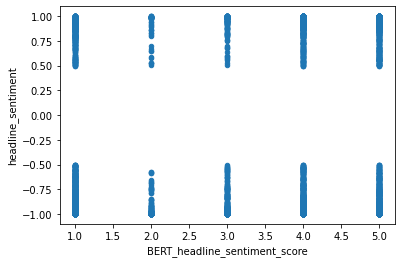

In [50]:
df[['headline_sentiment', 'BERT_headline_sentiment_score']].plot.scatter(x='BERT_headline_sentiment_score', y='headline_sentiment')

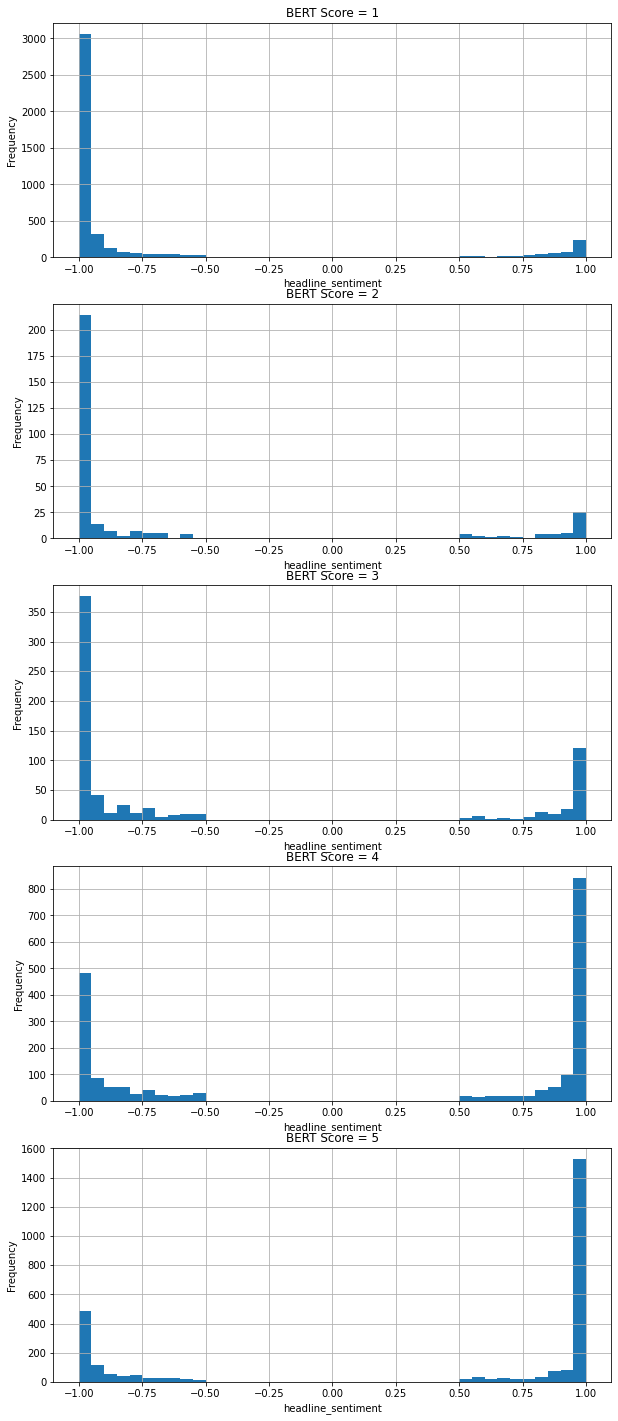

In [61]:
fig, axes = plt.subplots(nrows=len(df['BERT_headline_sentiment_score'].unique()), ncols=1, figsize=(10, 25))

# iterate over unique values of 'x' and create a histogram for each one
for i, x_val in enumerate(sorted(df['BERT_headline_sentiment_score'].unique())):
    df[df['BERT_headline_sentiment_score'] == x_val]['headline_sentiment'].plot.hist(ax=axes[i], title=f'BERT Score = {x_val}', bins=40)
    axes[i].set_xlabel('headline_sentiment')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

In [60]:
df['BERT_headline_sentiment_score'].corr(df['headline_sentiment'])

0.5366396077780085